In [1]:
import re
import cv2
import time
import random
import plotly.express as px
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

import config as c
from utils.image_processing import crop_image
import utils.model as model_factory
from utils.dataset import get_train_data, get_test_data

plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def get_height_map(img):
    m = np.zeros((30))
    for r in range(0, 30, 2):
        mask = create_circular_mask(80, 80, radius=r) * (~create_circular_mask(80, 80, radius=r-1))
        m[r] = np.sum(mask * img) / np.sum(mask)
    m -= m.min()
    m /= m.max()
    return m

def get_histogram_map(img, radius_0=7, radius_1=30):
    mask = create_circular_mask(80, 80, radius=radius_1) * (~create_circular_mask(80, 80, radius=radius_0))
    m = np.histogram(img[mask], range=(80, 120), bins=40)[0]
    
    return m

def get_img_spector(img):
    sum_img = np.sum(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    std_img = np.std(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    
    histogram_map_0_7 = get_histogram_map(img, 0, 6)
    histogram_map_7_30 = get_histogram_map(img, 6, 30)
    img = sp.ndimage.filters.gaussian_filter(img, [5.0, 5.0])
    
    height_map = get_height_map(img)
    spector = np.concatenate([histogram_map_0_7, histogram_map_7_30, height_map, sum_img, std_img])#.reshape(-1, 80)
    return spector

def get_circular_ratio(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.995)#112
    r = np.sqrt(np.sum(gaussian_mask)/np.pi)
    mask = create_circular_mask(250, 250, radius=r)
    return np.sum(mask*gaussian_mask)/np.sum(mask+gaussian_mask)

def get_bright_sum(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.98)#112
    return np.sum(img[gaussian_mask]-100.4)/1000

In [3]:
df = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(250, 250), values_linear_transformation=False, center_by_max=False, short_load=False, distance_matrices=False, return_as_dataframe=True)
df['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df['img_250'])))
df['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df['img_250'])))

100%|██████████| 13404/13404 [00:06<00:00, 2172.10it/s]


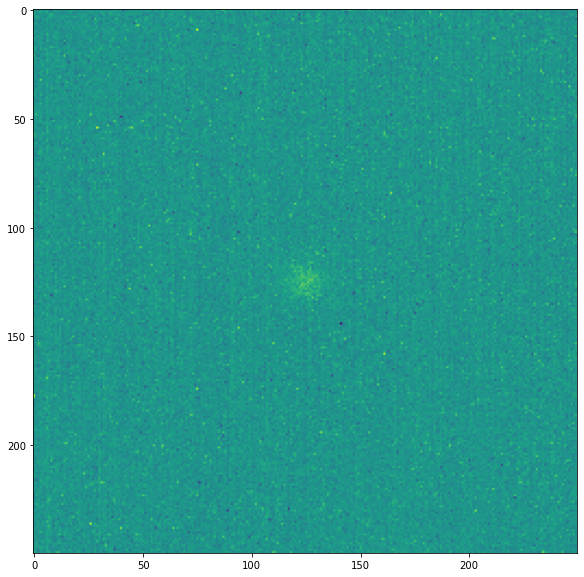

In [4]:
plt.imshow(df['img_250'][0])

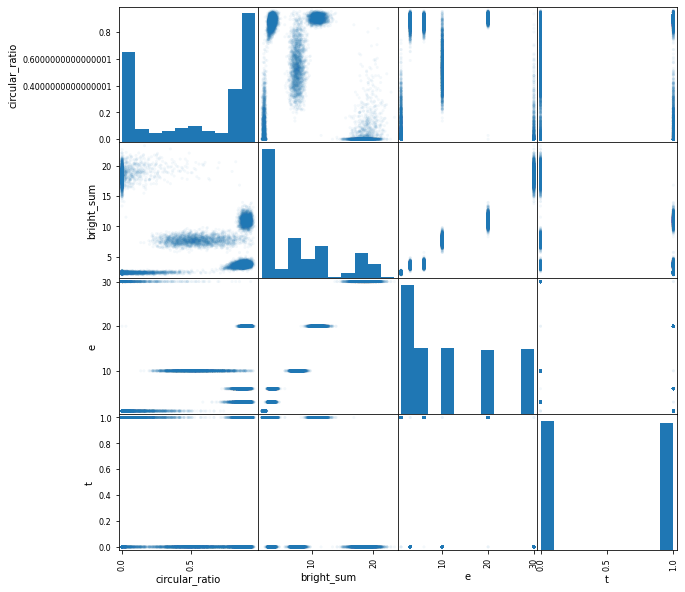

In [5]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[['circular_ratio', 'bright_sum', 'e', 't']], alpha=0.05, figsize=(10, 10));

In [6]:
np.sum((df.circular_ratio<0.8)&(df.t==0)&(df.bright_sum>6))

4370

In [7]:
np.sum((df.circular_ratio<0.8)&(df.t==1)&(df.bright_sum>6))

0

In [8]:
df = df[~((df.circular_ratio<0.8)&(df.t==0)&(df.bright_sum>6))]

In [9]:
df['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df['img_250']))

100%|██████████| 9034/9034 [00:03<00:00, 2507.35it/s]


In [10]:
df['spector'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(df['img_80']))

100%|██████████| 9034/9034 [00:22<00:00, 395.15it/s]


In [11]:
df.head()

,t,e,img_250,circular_ratio,bright_sum,img_80,spector
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....",0.884146,3.486998,"[[93.0, 105.0, 104.0, 98.0, 98.0, 104.0, 104.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....",0.925234,10.607998,"[[102.0, 101.0, 101.0, 98.0, 100.0, 102.0, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....",0.913313,9.111998,"[[101.0, 100.0, 102.0, 101.0, 100.0, 102.0, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...",0.919255,10.104999,"[[97.0, 100.0, 96.0, 98.0, 100.0, 99.0, 103.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...",0.878419,12.223998,"[[99.0, 107.0, 99.0, 101.0, 103.0, 100.0, 101....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
x = np.concatenate([df['spector'].to_numpy().tolist(), df[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df.t.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [14]:
model = CatBoostClassifier(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(model.predict(x_train), y_train), roc_auc_score(model.predict(x_test), y_test))

0.9967366568241658 0.9939217977484157


In [15]:
model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(model.predict(x_train)>0.5, y_train), roc_auc_score(model.predict(x_test)>0.5, y_test))

0.9862715001219157 0.9879852178704801


In [16]:
reg = LinearRegression().fit(x_train, y_train)
reg.score(x_train, y_train)


print(roc_auc_score(reg.predict(x_train)>0.5, y_train), roc_auc_score(reg.predict(x_test)>0.5, y_test))

0.9985209573063257 0.9983412746661534


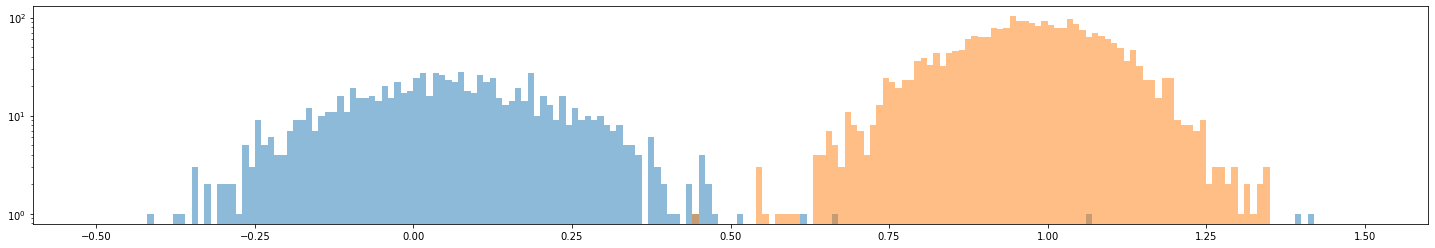

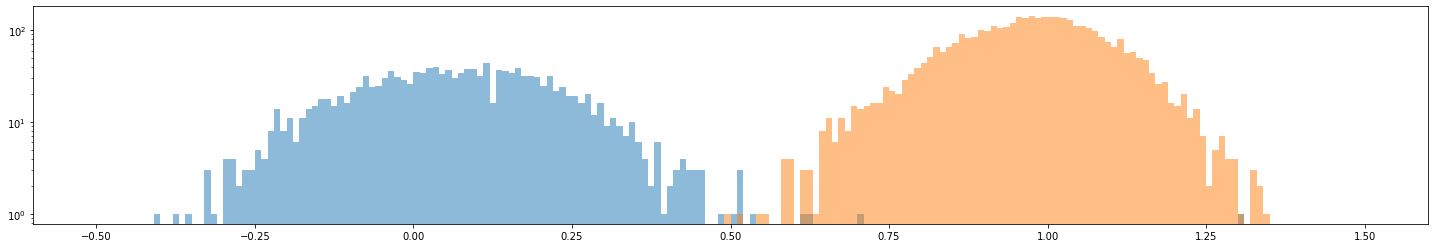

In [17]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(reg.predict(x_test[y_test.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(reg.predict(x_test[y_test.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(reg.predict(x_train[y_train.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(reg.predict(x_train[y_train.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [18]:
df_t0 = df[df.t==0]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [19]:
model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(model.predict(x_train), y_train), mean_absolute_error(model.predict(x_test), y_test))

0.06692537757382042 0.054302877378209484


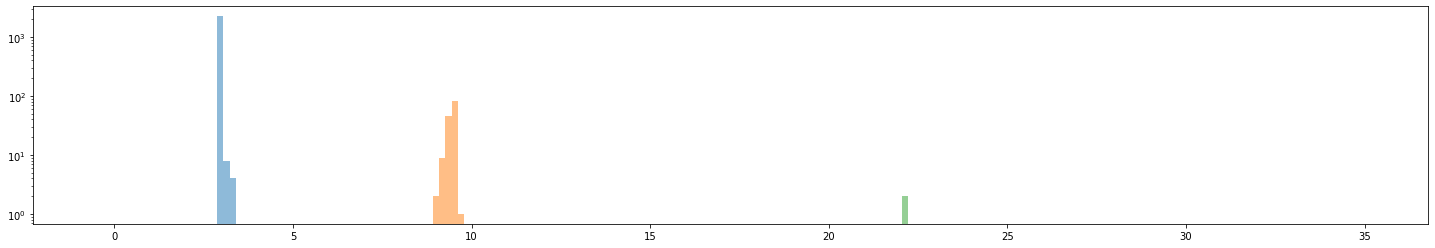

In [20]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(model.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(model.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(model.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

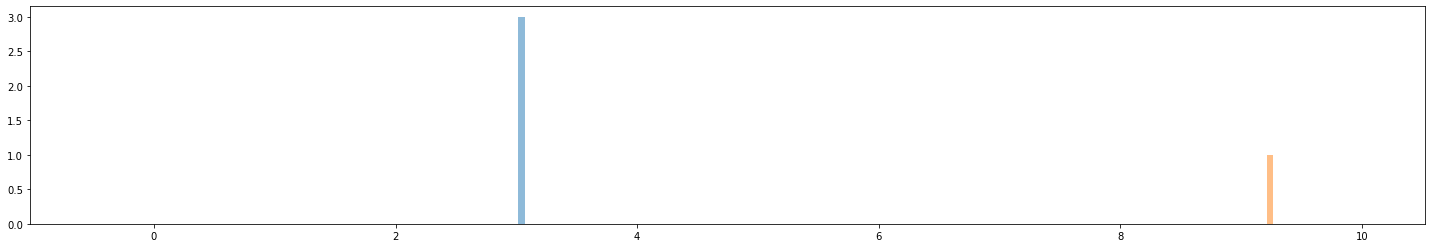

In [21]:
df_t0 = df[df.t==0]
df_t0=df_t0[df_t0.e.isin([1, 6, 20])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)

plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(model.predict(x[y.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 10))
plt.hist(model.predict(x[y.reshape(-1)==6]), bins=200, alpha=0.5, range=(-0.5, 10))
plt.show()

In [13]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([1, 6, 20])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [14]:
model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(model.predict(x_train), y_train), mean_absolute_error(model.predict(x_test), y_test))

0.3600571974077402 0.3578041860660763


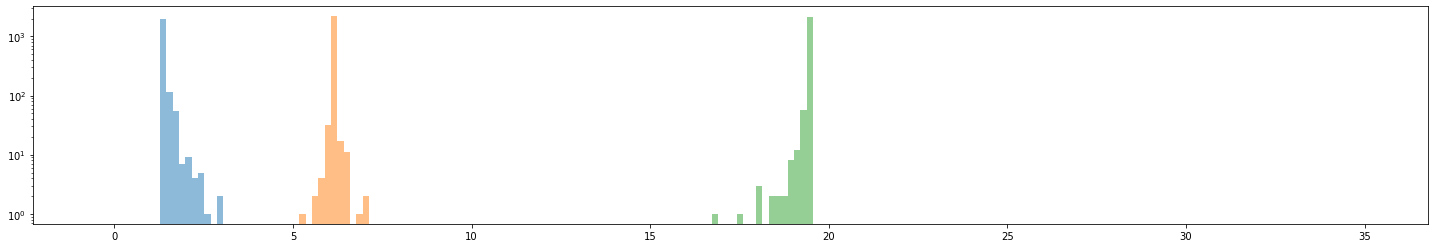

In [17]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(model.predict(x[y.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(model.predict(x[y.reshape(-1)==6]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(model.predict(x[y.reshape(-1)==20]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

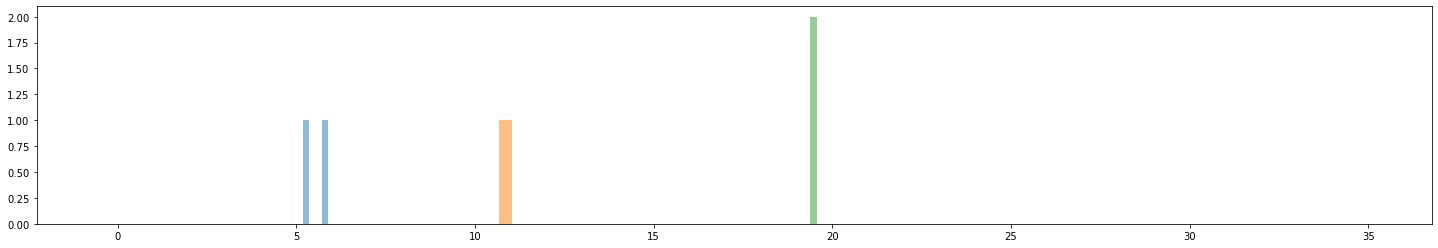

In [20]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)

plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(model.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(model.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(model.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.show()